# Heart disease prediction: Using different attributes to determine the presence of heart disease in patients of Hungary

# Introduction
Heart disease, or cardiovascular disease, refers to conditions affecting the heart, often involving narrowed or blocked blood vessels that can lead to a heart attack. Both men and women face increased risk with age (Jousilahti et al., 1999). High cholesterol can lead to fatty deposits in blood vessels, increasing the risk of blockages and heart attacks (Mayo Clinic, 2023). Research indicates that men tend to have a higher risk at a younger age compared to women (Jousilahti et al., 1999). Age, sex, and cholesterol levels are fundamental factors in cardiovascular health, each playing an important role in determining the risk of an individual in terms of heart disease. With these risk factors in mind, we aim to classify patients' likelihood of heart disease using age, sex, and cholesterol levels.

Therefore, the question we want to answer is: How does the combination of **age**, **sex**, and **cholesterol levels** influence the likelihood of developing heart disease in individuals? 

In order to answer this question, we will be using the knn classifier. By utilizing the KNN classifier, we aim to build a predictive model to classify individuals as either having or not having heart disease in the dataset.The data will be taken from the Hungary Heart Disease database (“reprocessed. Hungarian.data''); a data set intended to determine the presence of heart disease in patients of Hungary. It contains data on 14 variables, including age, sex, etc. 

The columns in the data contains the following information: 

* age = age in years 
* sex = gender of the patients; (1 = male; 0 = female)
* cp = chest pain type
* trestbps = resting blood pressure 
* chol = serum cholestoral in mg/dl
* fbs = fasting blood sugar > 120 mg/dl
* restecg = resting electrocardiographic results
* thalach = maximum heart rate achieved
* exang = exercise induced angima 
* oldpeak = ST depression induced by exercise relative to rest
* slope = the slope of the peak exercise ST segment; (1 = upflow, 2 = flat, 3 = downsloping) 
* ca = number of major vessels (0-3) colored by flourosopy
* thal = 3 = normal; 6 = fixed defect; 7 = reversable defect
* num = diagnosis of heart disease 
 

In [1]:
#setting the seed and loading the needed packages
set.seed(18)
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `trestbps = as.numeric(trestbps)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chol = as.numeric(chol)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `thalach = as.numeric(thalach)`.
Caused by warning:
! NAs introduced by coercion”


age,sex,chol,diagnosis
<dbl>,<fct>,<dbl>,<fct>
40,male,289,Healthy
49,female,180,Sick
37,male,283,Healthy
⋮,⋮,⋮,⋮
48,male,211,Healthy
47,female,257,Healthy
53,male,182,Healthy


`summarise()` has grouped output by 'diagnosis'. You can override using the
`.groups` argument.


diagnosis,sex,mean_age,mean_chol,count
<fct>,<fct>,<dbl>,<dbl>,<int>
Healthy,male,45.85393,243.7407,89
Healthy,female,47.69231,240.7021,52
Sick,male,49.31884,268.1077,69
Sick,female,49.30000,291.2000,10


Warning message:
“Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`).”


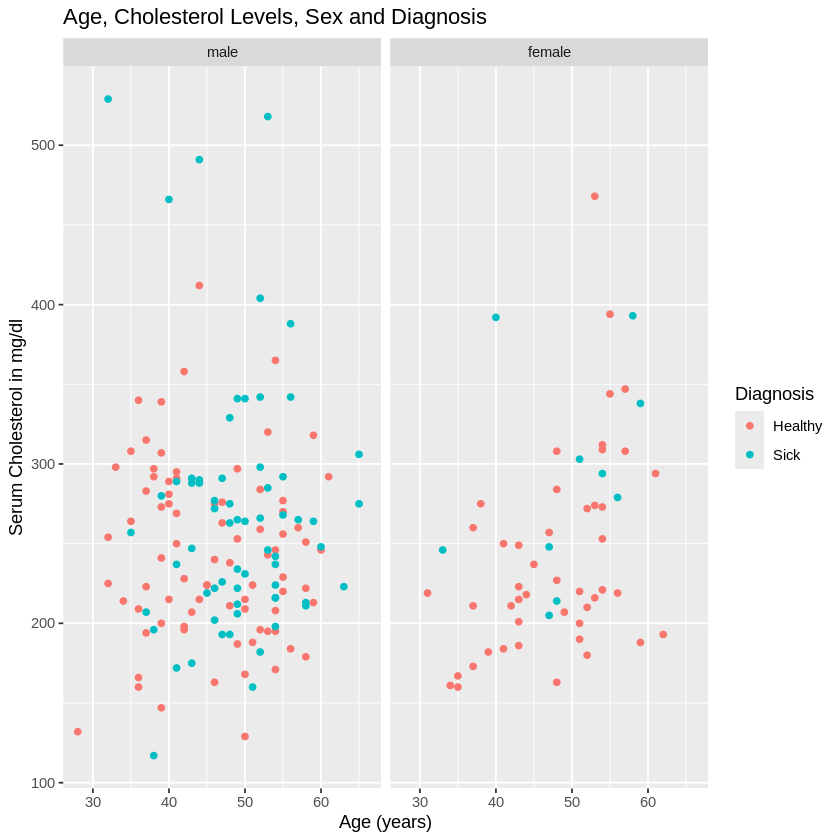

In [11]:
#copying the code from the proposal over
#loading in the data
url <- "https://raw.githubusercontent.com/ANGUO17/dsci-100-2023w2-group-06/main/heart%2Bdisease/reprocessed.hungarian.data"

data <- read.table(url) 
#cleaning the data
data <- data.frame(lapply(data, function(x) gsub("-9", "NA", x)))
           
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol" , "fbs", 
                    "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
                    "thal", "num")

data_processed <- data |>
    mutate(age = as.numeric(age)) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(chol = as.numeric(chol)) |>
    mutate(thalach = as.numeric(thalach)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical angina" = "1", "atypical angina" = "2", 
                                        "non-anginal pain" = "3" , "asymptomatic" = "4" )) |>
    mutate(fbs = as_factor(fbs)) |>
    mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0" )) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(restecg = fct_recode(restecg, "normal" = "0", "abnormal" = "1" )) |>
    mutate(exang = as_factor(exang)) |>
    mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0" )) |>
    mutate(slope = as_factor(slope)) |>
    mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal, "normal" = "3", "fixed defect" = "6", "reversable defect" = "7" )) |>
    mutate(diagnosis = as_factor(num)) |>
    mutate(diagnosis = fct_recode(diagnosis, "Sick" = "1","Sick" = "2" ,"Sick" = "3","Sick" = "4", "Healthy" = "0" )) |>
    select(age, sex, chol, diagnosis)
data_processed                          
#splitting the data into training and testing sets
data_split <- initial_split(data_processed, prop = 0.75, strata = diagnosis)  

data_training <- training(data_split)

data_testing <- testing(data_split)
#summarizing the training data
data_summarized <- data_training |>
    group_by(diagnosis, sex) |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_chol = mean(chol, na.rm = TRUE),
              count = n())
data_summarized
#creating a visualization of the training data
training_plot <- data_training|> ggplot(aes(x = age, y = chol, color = diagnosis)) + 
    geom_point() + facet_grid(cols = vars(sex)) + labs(x = "Age (years)", y = "Serum Cholesterol in mg/dl", color = "Diagnosis", title = "Age, Cholesterol Levels, Sex and Diagnosis" )
training_plot

In [3]:

#further cleaning the training data
data_training2 <- data_training |>
   drop_na() |>
   mutate(sex = as.numeric(sex))

#creating the recipe
hungary_recipe <- recipe(diagnosis ~ age + sex + chol  , data = data_training2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#male = 1, female = 2

In [4]:


hungary_vfold <-  vfold_cv(data_training2, v = 5, strata = diagnosis)
hungary_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")


values <- tibble(neighbors = seq(from = 1 , to = 100, by = 1 ))

best_fit <- workflow() |>
    add_recipe(hungary_recipe) |>
    add_model(hungary_spec) |>
    tune_grid(resamples = hungary_vfold , grid = values) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean) |>
    arrange(desc(mean))
best_fit

neighbors,mean
<dbl>,<dbl>
23,0.6612718
24,0.6612718
25,0.6519861
⋮,⋮
42,0.5880662
39,0.5880604
40,0.5880604


[1] 23

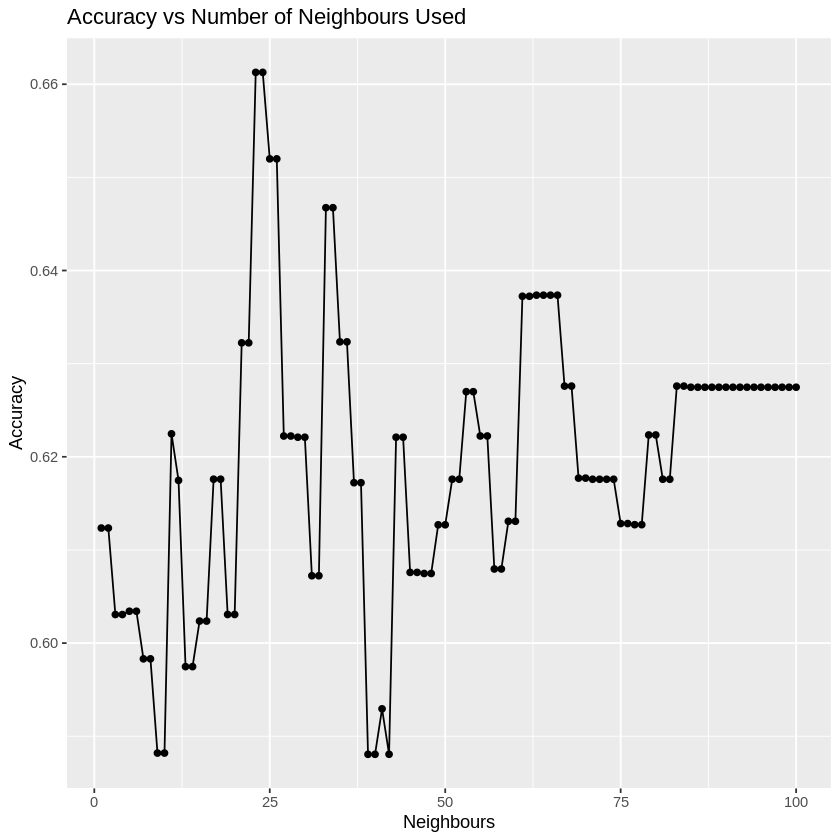

In [5]:
#finding the best k value for the model
best_k <- best_fit |>
    slice(1) |>
    pull(1)
best_k
#creating a visualization to see which k value yields the best accuracy
best_k_plot <- best_fit |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy", title = "Accuracy vs Number of Neighbours Used")
best_k_plot

In [6]:
#using the best k value for the model
hungary_spec2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

hungary_fit <- workflow() |>
    add_recipe(hungary_recipe) |>
    add_model(hungary_spec2) |>
    fit(data = data_training2)
#further cleaning the testing data
data_testing2 <- data_testing |>
    drop_na() |>
    mutate(sex = as.numeric(sex)) 


hungary_predictions <- predict(hungary_fit, data_testing2) |>
    bind_cols(data_testing2)

#accuracy, precision and recall checks
hungary_accuracy <- hungary_predictions |>
     metrics(truth = diagnosis, estimate = .pred_class) |>
     filter(.metric == "accuracy")
 hungary_accuracy

hungary_predictions |> pull(diagnosis) |> levels()

hungary_precision <- hungary_predictions |>
     precision(truth = diagnosis, estimate = .pred_class, event_level="second") |>
     filter(.metric == "precision")
hungary_precision

hungary_recall <- hungary_predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level = "second") |>
    filter(.metric == "recall")
hungary_recall
    
#confusion matrix
hungary_conf_mat <- hungary_predictions |>
     conf_mat(truth = diagnosis , estimate = .pred_class)
hungary_conf_mat   


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7164179


[1] "Healthy" "Sick"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7142857


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4


          Truth
Prediction Healthy Sick
   Healthy      38   15
   Sick          4   10

In [7]:
#comparing our model with a majority classifier
hungary_proportions <- data_training2 |>
    group_by(diagnosis) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(data_training2))
hungary_proportions


diagnosis,count,percent
<fct>,<int>,<dbl>
Healthy,128,62.7451
Sick,76,37.2549


In [8]:
#loading and cleaning the Clevleland data to see how good our Hungary model works on patients in Cleveland
url <- "https://raw.githubusercontent.com/ANGUO17/dsci-100-2023w2-group-06/main/heart%2Bdisease/processed.cleveland.data"

cleveland_data <- read_csv(url, col_names = FALSE)


colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol" , "fbs", 
                    "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
                    "thal", "num")


cleveland_data_processed <- cleveland_data |>
    mutate(age = as.numeric(age)) |>
    mutate(trestbps = as.numeric(trestbps)) |>
    mutate(chol = as.numeric(chol)) |>
    mutate(thalach = as.numeric(thalach)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical angina" = "1", "atypical angina" = "2", 
                                        "non-anginal pain" = "3" , "asymptomatic" = "4" )) |>
    mutate(fbs = as_factor(fbs)) |>
    mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0" )) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(restecg = fct_recode(restecg, "normal" = "0", "abnormal" = "1" )) |>
    mutate(exang = as_factor(exang)) |>
    mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0" )) |>
    mutate(slope = as_factor(slope)) |>
    mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal, "normal" = "3", "fixed defect" = "6", "reversable defect" = "7" )) |>
    mutate(diagnosis = as_factor(num)) |>
    mutate(diagnosis = fct_recode(diagnosis, "Sick" = "1","Sick" = "2" ,"Sick" = "3","Sick" = "4", "Healthy" = "0" )) |>
    select(age, sex, chol, diagnosis)

cleveland_data_processed       


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `thal = fct_recode(thal, normal = "3", `fixed defect` = "6",
  `reversable defect` = "7")`.
Caused by warning:
! Unknown levels in `f`: 3, 6, 7”


age,sex,chol,diagnosis
<dbl>,<fct>,<dbl>,<fct>
63,male,233,Healthy
67,male,286,Sick
67,male,229,Sick
⋮,⋮,⋮,⋮
57,male,131,Sick
57,female,236,Sick
38,male,175,Healthy


In [9]:
#using the same process from the Hungary data set
cleveland_clean <- cleveland_data_processed |>
    mutate(sex = as.numeric(sex))

cleveland_predictions <- predict(hungary_fit, cleveland_clean) |>
                      bind_cols(cleveland_data_processed)

#checking for accuracy, precision and recall
cleveland_metrics <- cleveland_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
cleveland_metrics

cleveland_predictions |> pull(diagnosis) |> levels()

cleveland_precision <- cleveland_predictions |>
     precision(truth = diagnosis, estimate = .pred_class, event_level="second") |>
     filter(.metric == "precision")
cleveland_precision

cleveland_recall <- cleveland_predictions |>
    recall(truth = diagnosis, estimate = .pred_class, event_level = "second") |>
    filter(.metric == "recall")
cleveland_recall
#calling the confusion matrix for Cleveland
cleveland_conf_mat<- cleveland_predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)
cleveland_conf_mat


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5115512


[1] "Healthy" "Sick"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2631579


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.03597122


          Truth
Prediction Healthy Sick
   Healthy     150  134
   Sick         14    5

In [10]:
#majority classfier for Cleveland
cleveland_proportions <- cleveland_data_processed |>
    group_by(diagnosis) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(cleveland_data_processed))
cleveland_proportions

diagnosis,count,percent
<fct>,<int>,<dbl>
Healthy,164,54.12541
Sick,139,45.87459


Each report should include the following sections:

Title

Introduction:
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and describe the dataset that was used to answer the question

Methods & Results:
describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend

Discussion:
summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well.
hint - you can use your proposal as a basis for your final report